<font size="+3">Datalayer</font>

# Overview

The Hera datalayer serves as a datalake, utilizing MongoDB to store metadata that describes data properties and links to corresponding data files. Due to the extensive nature of data generated from measurements or simulations, it's common to store data on disk while retaining only metadata in the database. Each database entry, termed a 'document,' represents a singular data piece (pandas, dask, xarray, or any other data) associated with a specific project, requiring the specification of a project name during the addition of a document to the database.

As MongoDB is a NoSQL database, metadata for each data piece is presented in JSON format, creating a hierarchical data structure. Users can query data pieces based on the JSON structure, specifying queries using the [MongoEngine query language](https://docs.mongoengine.org/guide/querying.html).

In basic usage, users add data documents to the database by providing metadata and specifying the data path. Upon addition, users define the data format. This definition allows users to employ the `getData()` method, enabling them to load the data while considering the data format for suitable loading strategies.


Each record denotes a piece of data from various sources. For simplicity, we define three distinct types of data documents:

<table>
  <tr>
      <th>Document kind</th>
    <th>Description</th>
  </tr>
  <tr>
    <td><b>Measurments</b></td>
    <td>Document references data from measurements or external data</td>
  </tr>
  <tr>
      <td><b>Simulations</b></td>
      <td>Document references data from simulations</td>      
    </tr>
  <tr>
      <td><b>Cache</b></td>
    <td>Document references data after computation (either measurement or simulaiton data)</td>
  </tr>
</table>

Each document holds the following properties: 
<table>
  <tr>
      <th>Property name</th>
    <th>Description</th>
  </tr>
  <tr>
    <td><b>projectName</b></td>
    <td>The term used to identify the project to which a particular piece of information belongs.</td>
  </tr>
  <tr>
      <td><b>type</b></td>
      <td>A user-define string to identify the data</td>      
    </tr>
  <tr>
    <td><b>dataFormat</b></td>
    <td>The format of the data the document stores</td>
  </tr>
  <tr>
    <td><b>resource</b></td>
    <td>The resource that the document holds (for example the path to the file)</td>
  </tr>

</table>

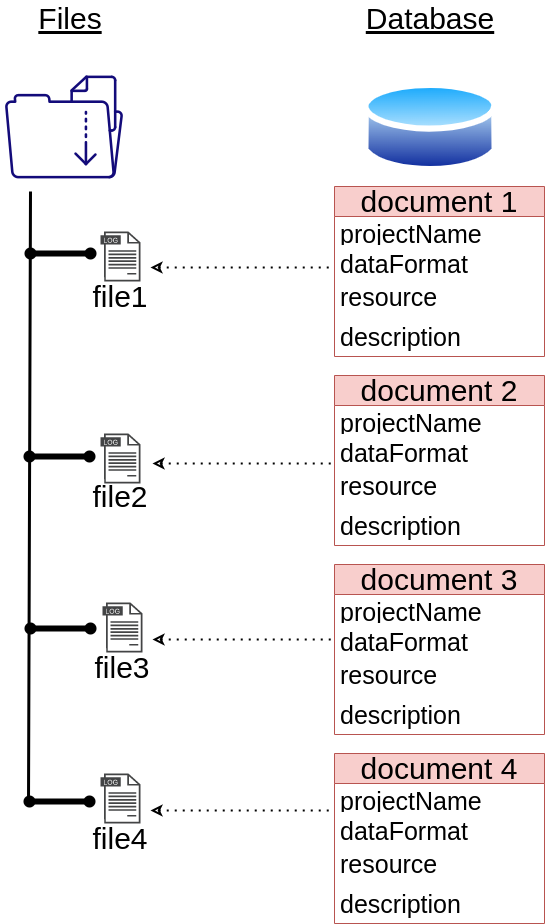

In [23]:
from IPython.display import Image
Image(filename="Hera-DB.png")

Each user has its own database that stores documents, but it is also possible to access
a different databases.

<a id="setup"></a>

# Setup


The database is configurated in the file 
`$HOME/.pyhera/config.json`. 

The structure of the config.json is

```javascript
{
        <connection name 1> : {
            "dbIP": "DB IP",
            "dbName": "...",
            "password": "..." ,
            "username": "..."
        },
        <connection name 1> : {
            "dbIP": "DB IP",
            "dbName": "...",
            "password": "..." ,
            "username": "..."
        }
    }
```

The default connection is the **default with the linux user name**.
It is possible to add other database connections. See below on how
to access other databases.

# 10-minute tutorial

This tutorial demonstrate how to store and retrieve data from the database
with the default connection (the username of the linux system). 
Accesssing other connection is given in ... (TBD). 

First, lets create some mock-up data that we can store in the DB.   

In [2]:
import pandas
import numpy
from scipy.stats import norm

x = numpy.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)

dataset1 = pandas.DataFrame(dict(x=x,y=norm.pdf(x,loc=0,scale=1)))
dataset2 = pandas.DataFrame(dict(x=x,y=norm.pdf(x,loc=0,scale=0.5)))
dataset3 = pandas.DataFrame(dict(x=x,y=norm.pdf(x,loc=0.5,scale=0.5)))

print(dataset1.head())

          x         y
0 -2.326348  0.026652
1 -2.279351  0.029698
2 -2.232354  0.033020
3 -2.185357  0.036632
4 -2.138360  0.040550


Now that we have data, we can save it. We would like to keep the connection between the data and the parameters that generated it. 
So that:

- **dataset1** is characterized by loc=0 and scale = 1 
- **dataset2** is characterized by loc=0 and scale = 0.5 
- **dataset3** is characterized by loc=0.5 and scale = 0.5

Therefore, we will save the loc and scale in the metadata.

Before we add the data to the DB, we need to save it to the disk

In [3]:
import os 

# getting the work directory
workingdir = os.path.join(os.path.abspath(os.getcwd()),"examples","datalayer")

dataset1File = os.path.join(workingdir,"dataset1.parquet")
dataset2File = os.path.join(workingdir,"dataset2.parquet")
dataset3File = os.path.join(workingdir,"dataset3.parquet")

Now we can save the dataset. We choose parquet for convinience, but it can be any other format.

In [4]:
dataset1.to_parquet(dataset1File,engine='fastparquet',compression='GZIP')
dataset2.to_parquet(dataset2File,engine='fastparquet',compression='GZIP')
dataset3.to_parquet(dataset3File,engine='fastparquet',compression='GZIP')

When we save the data to the database we need to define a project
and specify the project name. 

To do so, we need to import the project and create it with its name. 
For this example we will use the name `ExampleProject`.

In [5]:
from hera.datalayer import Project

projectName = "ExampleProject"

proj = Project(projectName=projectName)

## Adding data to the MongoDB 

Next, we add the documents to the database. To do this, we must specify the 'type' of the documents. This type is user-defined and enables the user to query all documents of this type.

For this example, we will add the data as a Measurement data. 

In [6]:
proj.addMeasurementsDocument( type="Distribution",
                             dataFormat=proj.datatypes.PARQUET,
                             resource=dataset1File,
                             desc=dict(loc=0,scale=1));

proj.addMeasurementsDocument(type="Distribution",
                             dataFormat=proj.datatypes.PARQUET,
                             resource=dataset2File,
                             desc=dict(loc=0,scale=0.5));

proj.addMeasurementsDocument(type="Distribution",
                             dataFormat=proj.datatypes.PARQUET,
                             resource=dataset3File,
                             desc=dict(loc=0.5,scale=0.5));

## Getting the data

### Getting one record back
Now we will query the database for all the records in which loc=0 and scale=1.

In [7]:
List1 = proj.getMeasurementsDocuments(loc=0,scale=1)

print(f"The number of documents obtained from the query {len(List1)} ")
item0 = List1[0]

The number of documents obtained from the query 1 


Note that for consistency the query always returns a list.

The description of the record that matched the query is

In [8]:
import json 

print("The description of dataset 1")
print(json.dumps(item0.desc, indent=4, sort_keys=True))

The description of dataset 1
{
    "loc": 0,
    "scale": 1
}


Now, we will extract the data.

Using the getData on item0 will retrieve the data 

In [9]:
dataset1FromDB = item0.getData()

Since the data is parquet, the library automatically returns a dask.DataFrame, where 
the data is not loaded until it is computed. 

Alternatively, we can pass the usePandas flag. This flag is used only 
when the datatype is PARQUET. 

In [10]:
dataset1FromDB = item0.getData(usePandas=True)

print(dataset1FromDB)

           x         y
0  -2.326348  0.026652
1  -2.279351  0.029698
2  -2.232354  0.033020
3  -2.185357  0.036632
4  -2.138360  0.040550
..       ...       ...
95  2.138360  0.040550
96  2.185357  0.036632
97  2.232354  0.033020
98  2.279351  0.029698
99  2.326348  0.026652

[100 rows x 2 columns]


### Getting multiple records back

The getMeasurementsDocuments returns all the records that match the criteria. 

Now, lets get all the records where loc=0

In [11]:
List2 = proj.getMeasurementsDocuments(loc=0)

print(f"The number of documents obtained from the query {len(List2)} ")

The number of documents obtained from the query 2 


As another example, let's retrieve all documents of the type 'Distribution'.

In [12]:
List3 = proj.getMeasurementsDocuments(type='Distribution')

print(f"The number of documents obtained from the query {len(List3)} ")

The number of documents obtained from the query 3 


## Updating the data.
The hera system holds the name of the file on the disk and loads the data from it. Therefore, if the datafile on the disk is overwitten, then the data of the record is changed

Lets multiply dataset1 by factor 2. The file name is saved in the resource attribute.

Note that if we just update the data and not the metadata, then we can use the resource property to 
save the new file. 

In [13]:
dataset1['y'] *=2
dataset1FileName = item0.resource
dataset1.to_parquet(dataset1FileName,engine='fastparquet',compression='GZIP',append=False)

In [14]:
dataset1FromDB = item0.getData().compute()
print(dataset1FromDB)

           x         y
0  -2.326348  0.053304
1  -2.279351  0.059397
2  -2.232354  0.066040
3  -2.185357  0.073264
4  -2.138360  0.081099
..       ...       ...
95  2.138360  0.081099
96  2.185357  0.073264
97  2.232354  0.066040
98  2.279351  0.059397
99  2.326348  0.053304

[100 rows x 2 columns]


## Updating the metadata.

Lets assume we want to add another property to the first record. To so we will update item0

In [15]:
item0.desc['new_attribute'] = "some data"
item0.save();

Lets requery the database to see what is the data there. 

In [16]:
item0_fromdb = proj.getMeasurementsDocuments(loc=0,scale=1)[0]
print(json.dumps(item0_fromdb.desc, indent=4, sort_keys=True))

{
    "loc": 0,
    "new_attribute": "some data",
    "scale": 1
}


## Deleting the metadata entry.

We delete the metadata records similarly to the way we add them

The following will delete one record. The simplest method is to erase the document object. 

In [17]:
item0.delete()

Lets query the database again to see if the record was deleted. 

<div class="alert alert-block alert-warning">
Note that the file on the disk is not deleted by deleting the record in the DB. 
</div>

In [18]:
List1 = proj.getMeasurementsDocuments(loc=0,scale=1)

print(f"The number of documents obtained from the query {len(List1)} ")

The number of documents obtained from the query 0 


Another option is to delete the records using the Project interface. 

In [19]:
deletedList1 = proj.deleteMeasurementsDocuments(loc=0)

Lets list all the data records that we deleted

In [20]:
for doc in deletedList1:
    print(json.dumps(doc, indent=4, sort_keys=True))

{
    "_cls": "Metadata.Measurements",
    "_id": {
        "$oid": "65a1d49d9b9128b1cb982b4c"
    },
    "dataFormat": "parquet",
    "desc": {
        "loc": 0,
        "scale": 0.5
    },
    "projectName": "ExampleProject",
    "resource": "/home/yehudaa/Development/hera/hera/doc/source/examples/datalayer/dataset2.parquet",
    "type": "Distribution"
}


## Deleting the data on the disk 

Now we can erase the file from the disk. It is saved in the resource property

In [21]:
import shutil

for doc in deletedList1:
    if os.path.isfile(doc['resource']):
          os.remove(doc['resource'])
    else:
        shutil.rmtree(doc['resource'])

## Delete all the metadata records 

A simple way to delete all the records (be careful)

In [22]:
[x.delete() for x in proj.getMeasurementsDocuments(type="Distribution")]

[None]